In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 10
%matplotlib inline
import sklearn
from datetime import datetime, timedelta

In [3]:
full_meteo = pd.read_csv("./formatted_data/full_meteo.csv", parse_dates=["DATE"])[["DATE", "MAX_TEMP"]]
full_meteo.head()

,DATE,MAX_TEMP
0,1975-01-01,8.1
1,1975-01-02,3.2
2,1975-01-03,4.5
3,1975-01-04,6.4
4,1975-01-05,7.0


In [4]:
test_df = full_meteo[full_meteo["DATE"] <= datetime(1975, 1, 2)]
test_df.head()

,DATE,MAX_TEMP
0,1975-01-01,8.1
1,1975-01-02,3.2


In [5]:
df_list = []
for i in range(7):
    df = full_meteo.copy()
    df["DATE"] = df["DATE"].apply(lambda x: x + timedelta(days=i))
    df = df.rename(columns={"MAX_TEMP": "MAX_TEMP_J-{}".format(str(i))})
    df_list.append(df)
    
final_df = df_list[0]
for df in df_list[1:]:
    final_df = pd.merge(final_df, df, on="DATE", how="left")

final_df["DAY_OF_YEAR"] = final_df["DATE"].apply(lambda x: x.timetuple().tm_yday)
final_df.head(20)

,DATE,MAX_TEMP_J-0,MAX_TEMP_J-1,MAX_TEMP_J-2,MAX_TEMP_J-3,MAX_TEMP_J-4,MAX_TEMP_J-5,MAX_TEMP_J-6,DAY_OF_YEAR
0,1975-01-01,8.1,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1975-01-02,3.2,8.1,NaN,NaN,NaN,NaN,NaN,2
2,1975-01-03,4.5,3.2,8.1,NaN,NaN,NaN,NaN,3
3,1975-01-04,6.4,4.5,3.2,8.1,NaN,NaN,NaN,4
4,1975-01-05,7.0,6.4,4.5,3.2,8.1,NaN,NaN,5
5,1975-01-06,8.1,7.0,6.4,4.5,3.2,8.1,NaN,6
6,1975-01-07,11.0,8.1,7.0,6.4,4.5,3.2,8.1,7
7,1975-01-08,10.3,11.0,8.1,7.0,6.4,4.5,3.2,8
8,1975-01-09,11.6,10.3,11.0,8.1,7.0,6.4,4.5,9
9,1975-01-10,8.2,11.6,10.3,11.0,8.1,7.0,6.4,10


In [6]:
meteo_df_train = final_df[(final_df["DATE"] <= datetime(2010, 1, 1)) & (final_df["DATE"] > datetime(1975, 1, 6))]
meteo_df_test = final_df[final_df["DATE"] > datetime(2010, 1, 1)]

x_train = meteo_df_train[["MAX_TEMP_J-1", "MAX_TEMP_J-2", "MAX_TEMP_J-3", "MAX_TEMP_J-4",
                          "MAX_TEMP_J-5", "MAX_TEMP_J-6", "DAY_OF_YEAR"]].values
y_train = meteo_df_train["MAX_TEMP_J-0"].values

x_test = meteo_df_test[["MAX_TEMP_J-1", "MAX_TEMP_J-2", "MAX_TEMP_J-3", "MAX_TEMP_J-4",
                          "MAX_TEMP_J-5", "MAX_TEMP_J-6", "DAY_OF_YEAR"]].values
y_test = meteo_df_test["MAX_TEMP_J-0"].values

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def print_scores_and_params(grid_search):
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
        print(np.sqrt(-mean_score), params)

param_grid = [
        {'n_estimators': [40, 50], 'max_features': [2, 4, 6]},
        {'bootstrap': [False], 'n_estimators': [10, 30], 'max_features': [4, 6]},
        ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(x_train, y_train)

print_scores_and_params(grid_search)

best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)
feature_importances = best_estimator.feature_importances_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_features=2, n_estimators=40 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_features=2, n_estimators=40, total=   0.5s
[CV] max_features=2, n_estimators=40 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .................. max_features=2, n_estimators=40, total=   0.5s
[CV] max_features=2, n_estimators=40 .................................
[CV] .................. max_features=2, n_estimators=40, total=   0.5s
[CV] max_features=2, n_estimators=40 .................................
[CV] .................. max_features=2, n_estimators=40, total=   0.5s
[CV] max_features=2, n_estimators=40 .................................
[CV] .................. max_features=2, n_estimators=40, total=   0.5s
[CV] max_features=2, n_estimators=50 .................................
[CV] .................. max_features=2, n_estimators=50, total=   0.6s
[CV] max_features=2, n_estimators=50 .................................
[CV] .................. max_features=2, n_estimators=50, total=   0.6s
[CV] max_features=2, n_estimators=50 .................................
[CV] .................. max_features=2, n_estimators=50, total=   0.6s
[CV] max_features=2, n_estimators=50 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.9s finished


2.8037249160017685 {'max_features': 2, 'n_estimators': 40}
2.801113165364306 {'max_features': 2, 'n_estimators': 50}
2.7992850299892647 {'max_features': 4, 'n_estimators': 40}
2.8037574189177765 {'max_features': 4, 'n_estimators': 50}
2.8188928836968303 {'max_features': 6, 'n_estimators': 40}
2.8082600535503923 {'max_features': 6, 'n_estimators': 50}
2.9614128911582034 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
2.884362011913668 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
3.1086386618196333 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}
3.027421783846948 {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
{'max_features': 4, 'n_estimators': 40}


/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


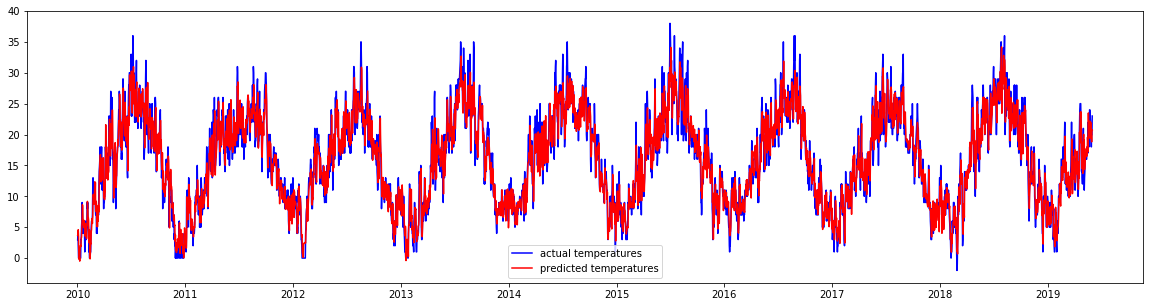

In [8]:
y_pred = best_estimator.predict(x_test)


def plot_meteo_pred(y_test, y_pred, dates):
    plt.figure(1, figsize=(20, 5))
    plt.plot(dates, y_test, label="actual temperatures", color="blue")
    plt.plot(dates, y_pred, label="predicted temperatures", color="red")
    plt.legend()
    plt.show()
    
plot_meteo_pred(y_test, y_pred, meteo_df_test["DATE"])

In [9]:
from sklearn.metrics import mean_squared_error
print("mean squared error: {}".format(mean_squared_error(y_pred, y_test)))
import math
print("root mean squared error: {}".format(math.sqrt(mean_squared_error(y_pred, y_test))))

mean squared error: 7.105514854887984
root mean squared error: 2.6656171621011118


root mean squared error 2010: 2.871588273469713


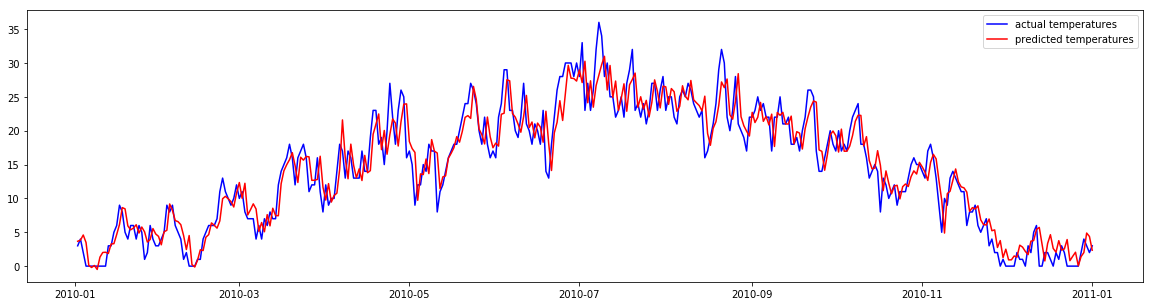

root mean squared error 2011: 2.6199415252807476


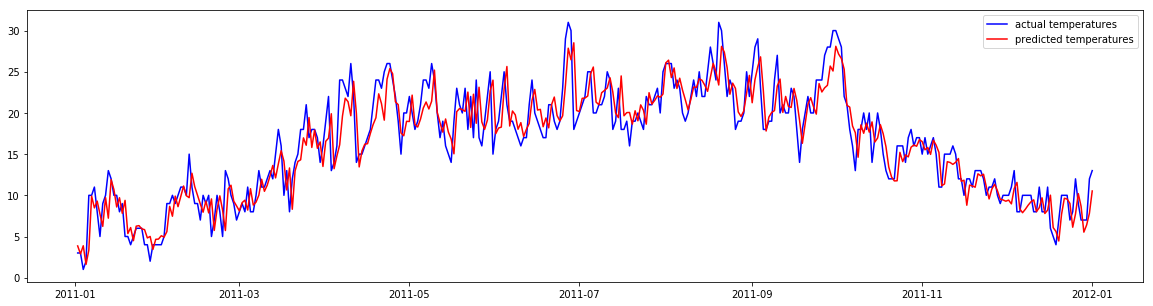

root mean squared error 2012: 2.418760122629344


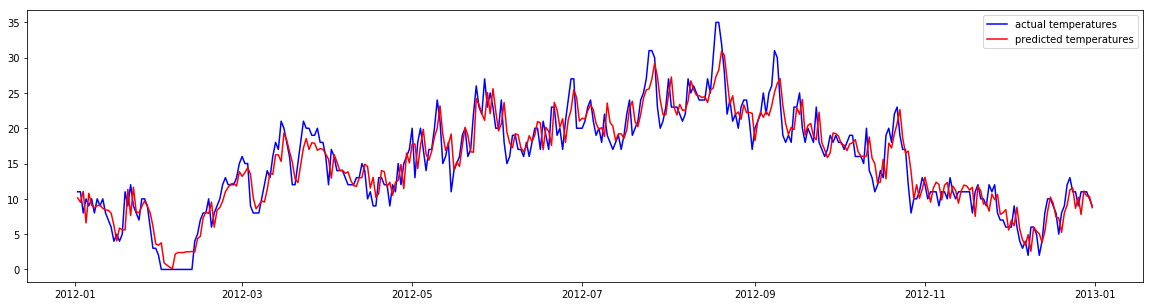

root mean squared error 2013: 2.6831065298800443


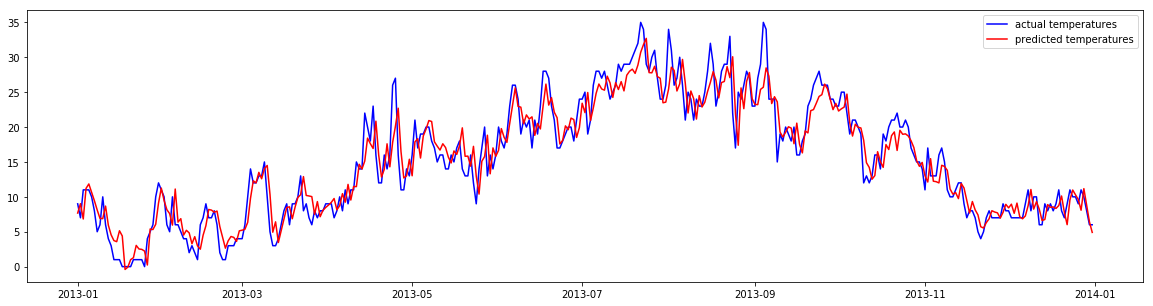

root mean squared error 2014: 2.5916826098116257


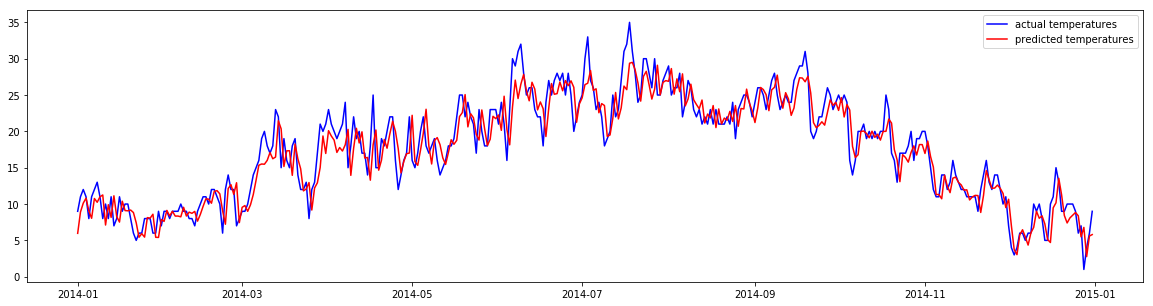

root mean squared error 2015: 3.090053034633761


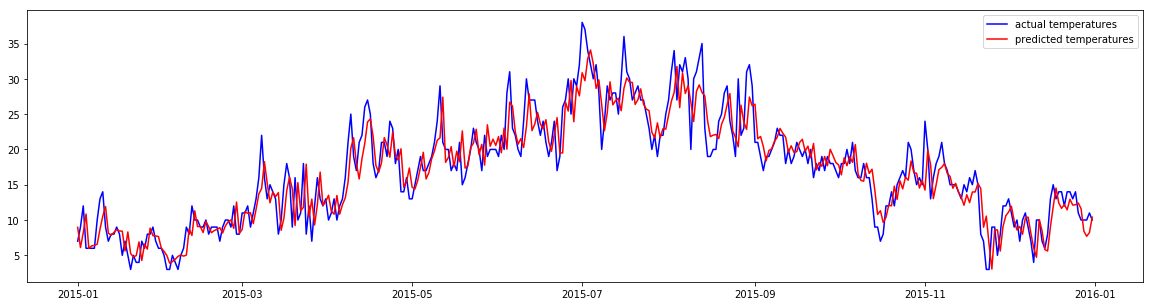

root mean squared error 2016: 2.526397914271004


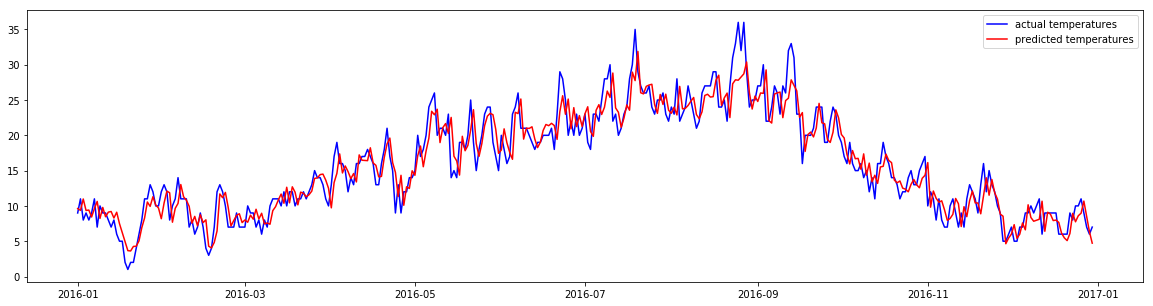

root mean squared error 2017: 2.414281168721621


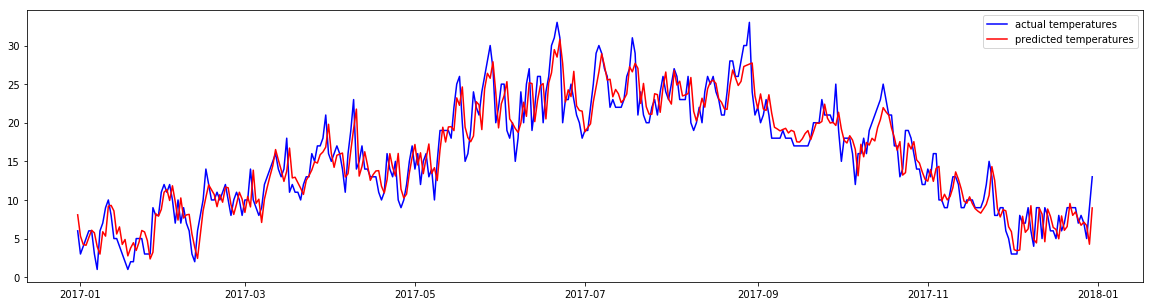

root mean squared error 2018: 2.7604340939399914


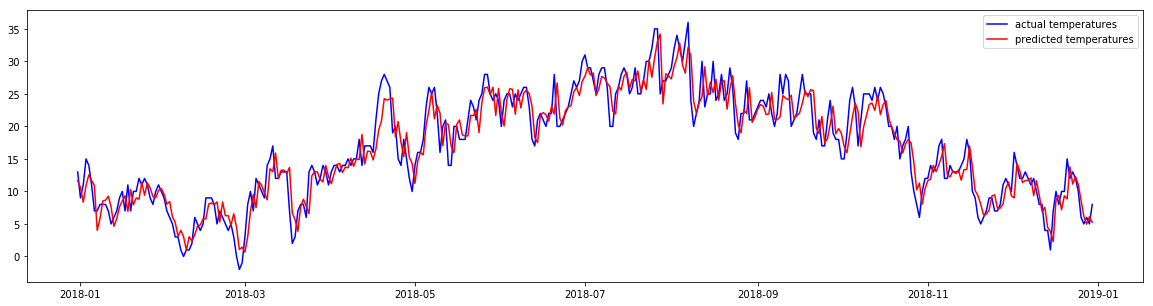

root mean squared error 2019: 2.523730530281251


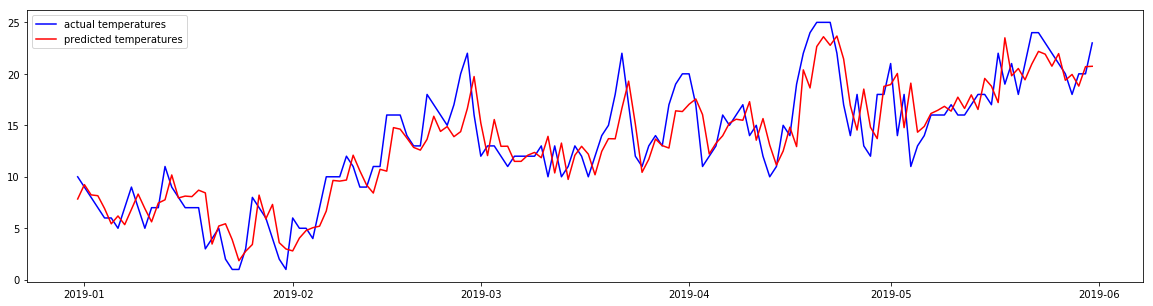

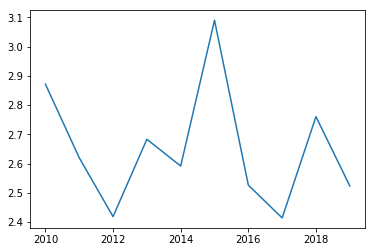

In [10]:
rmse_list = []
for i in range(10):
    year = 2010 + i
    y_test_year = y_test[i*365:min(len(y_test), (i+1)*365)]
    y_pred_year = y_pred[i*365:min(len(y_pred), (i+1)*365)]
    rmse = math.sqrt(mean_squared_error(y_pred_year, y_test_year))
    print("root mean squared error {}: {}".format(year, rmse))
    
    dates = meteo_df_test["DATE"].values[i*365:min(len(y_test), (i+1)*365)]
    plot_meteo_pred(y_test_year, y_pred_year, dates)
    rmse_list.append(rmse)

plt.plot(np.arange(2010, 2020, 1), rmse_list)
plt.show()

root mean squared error 2010-1: 1.802458448434619


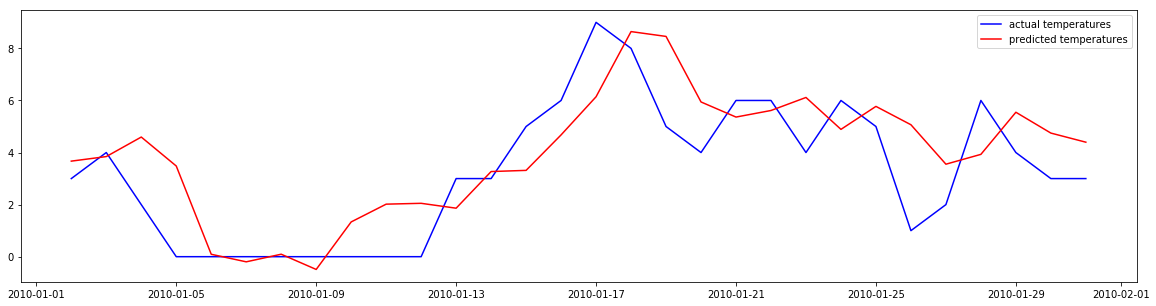

root mean squared error 2010-2: 1.867157822288554


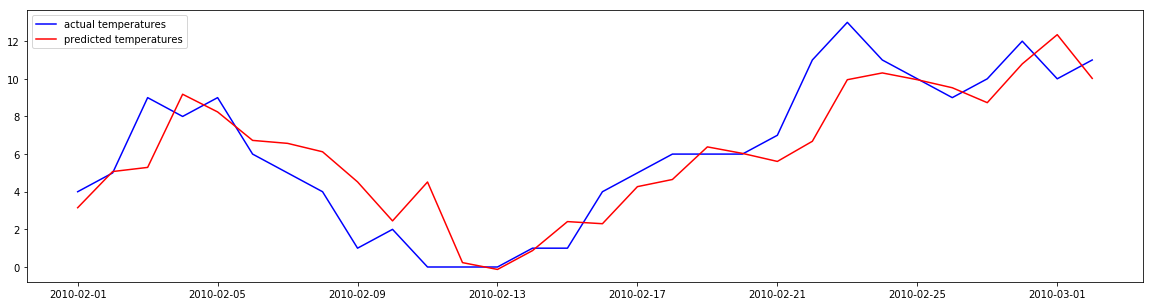

root mean squared error 2010-3: 2.6286746502119023


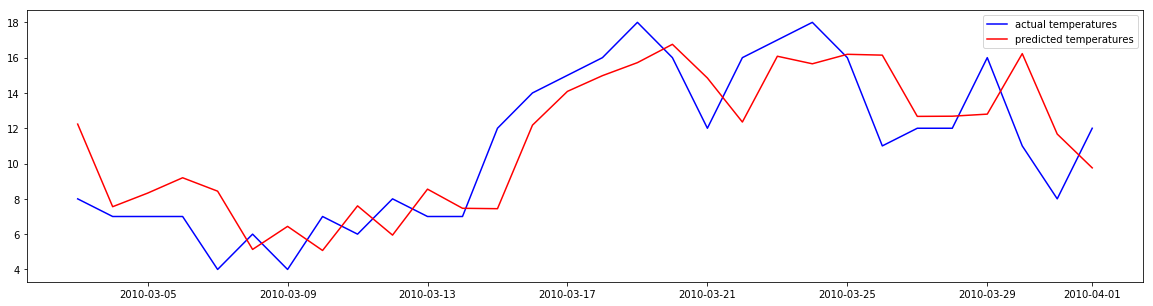

root mean squared error 2010-4: 3.6523711476245135


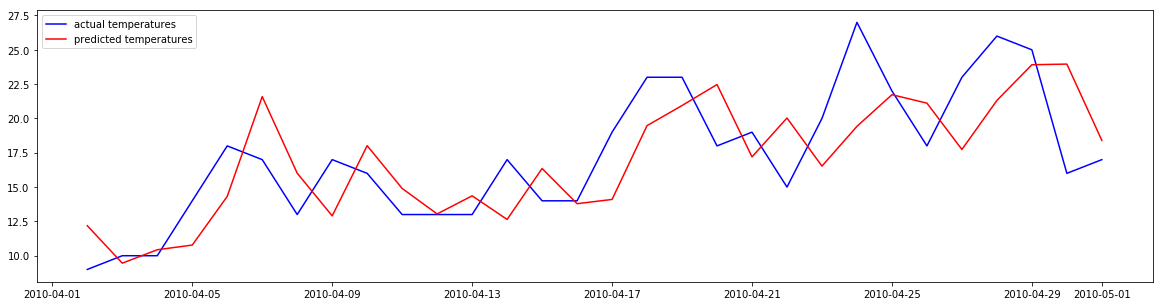

root mean squared error 2010-5: 2.9808127037772776


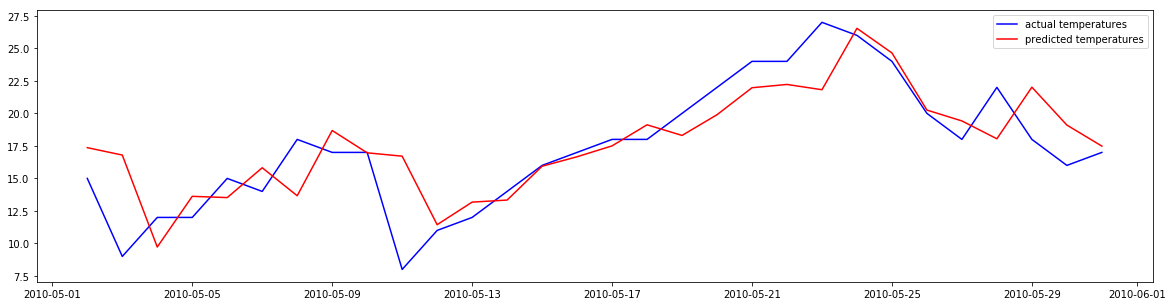

root mean squared error 2010-6: 3.7494520432991267


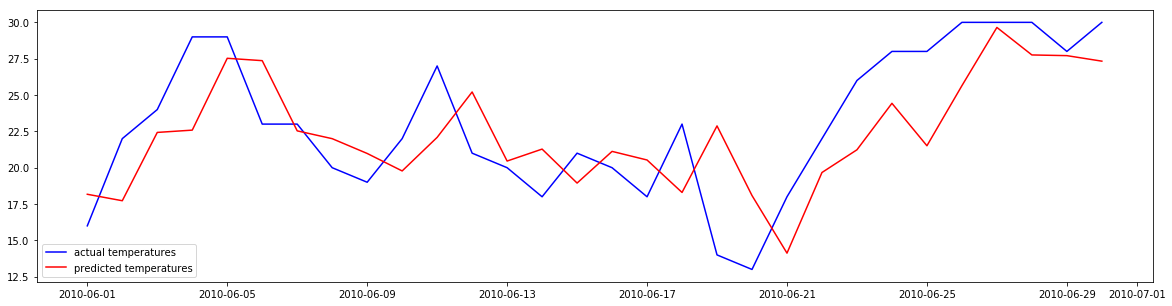

root mean squared error 2010-7: 3.854692351537279


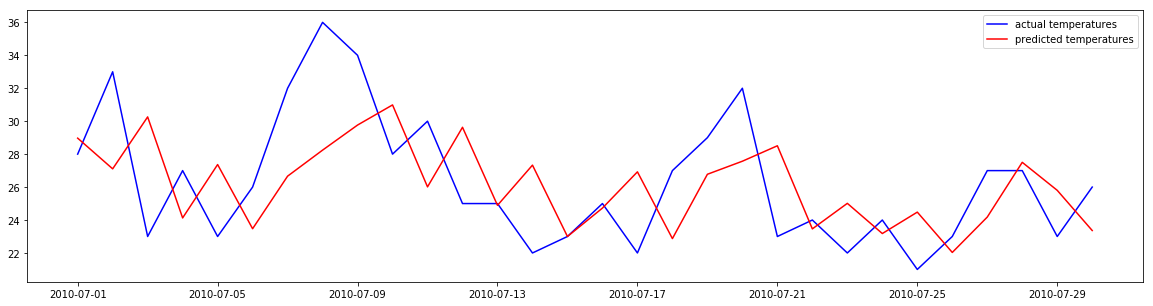

root mean squared error 2010-8: 3.2992169841241625


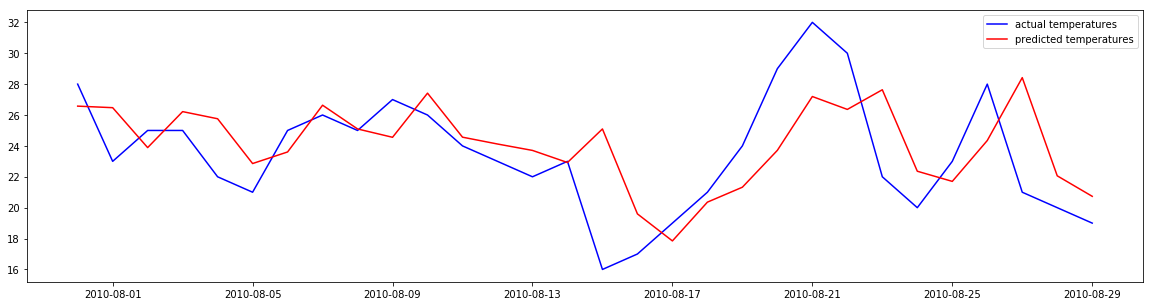

root mean squared error 2010-9: 2.786610022350934


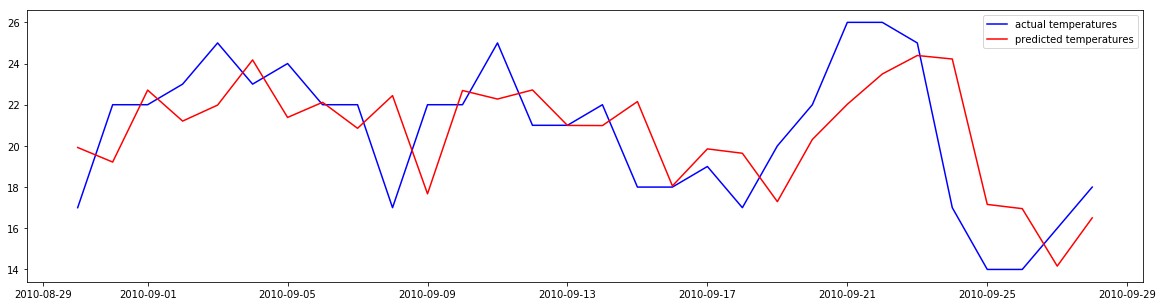

root mean squared error 2010-10: 2.380996377569692


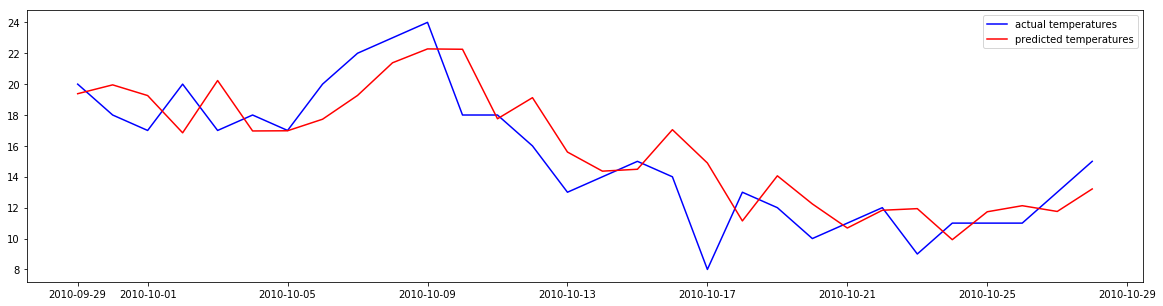

In [11]:
for i in range(10):
    year = str(2010) + "-" + str(i+1)
    y_test_year = y_test[i*30:min(len(y_test), (i+1)*30)]
    y_pred_year = y_pred[i*30:min(len(y_pred), (i+1)*30)]
    print("root mean squared error {}: {}".format(
        year,
        math.sqrt(mean_squared_error(y_pred_year, y_test_year))))
    
    dates = meteo_df_test["DATE"].values[i*30:min(len(y_test), (i+1)*30)]
    plot_meteo_pred(y_test_year, y_pred_year, dates)

In [12]:
# Root mean squared error if simply predicting the temperature of the previous day.
print("root mean squared error with previous day: {}".format(math.sqrt(mean_squared_error(y_test[1:], y_test[:-1]))))

root mean squared error with previous day: 2.749431097890779


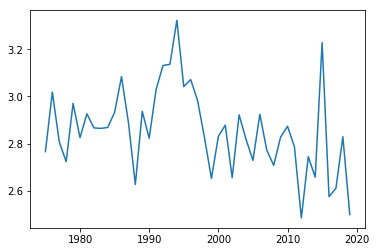

In [13]:
# Evolution of this root mean squared error throughout the years
rmse_list = []

for year in range(1975, 2020):
    vals = full_meteo[full_meteo["DATE"].apply(lambda x: x.year) == year]["MAX_TEMP"].values
    rmse = math.sqrt(mean_squared_error(vals[1:], vals[:-1]))
    rmse_list.append(rmse)
    
plt.plot(np.arange(1975, 2020, 1), rmse_list)
plt.show()

            DATE  MAX_TEMP_J-0  MAX_TEMP_J-1  MAX_TEMP_J-2  MAX_TEMP_J-3  \
15706 2018-01-01           9.0          13.0          13.0           9.0   

       MAX_TEMP_J-4  MAX_TEMP_J-5  MAX_TEMP_J-6  DAY_OF_YEAR  
15706           5.0           7.0           8.0            1  
[array([9.0, 13.0, 13.0, 9.0, 5.0, 7.0, 1], dtype=object)]


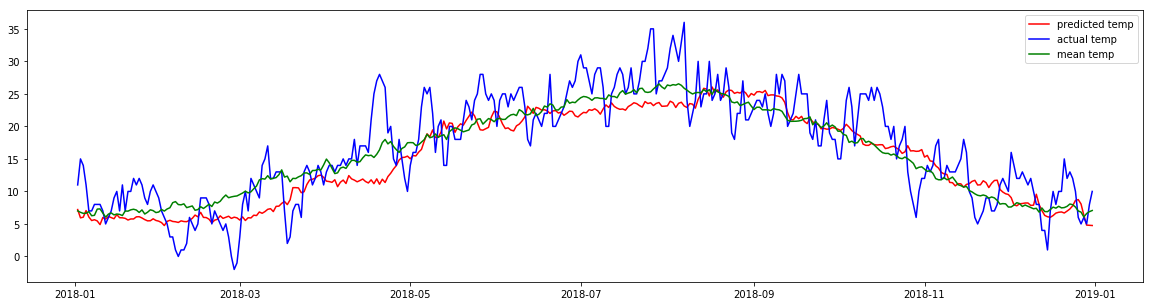

In [19]:
# Test at predicting the temperatures of 2019 in a dynamic way.
initial_date = datetime(2018, 1, 1)
end_date = datetime(2018, 12, 31)

initial_df = final_df[final_df["DATE"] == initial_date]
print(initial_df.head())
features = [np.append(initial_df.values[0][1:-2], 1)]
print(features)
date = initial_date + timedelta(days=1)
date_list = []
prediction_list = []

while date <= end_date:
    date_list.append(date)
    prediction = best_estimator.predict(features)
    prediction_list.append(prediction[0])
    features = [list(prediction) + list(features[0][:5]) + [features[0][-1] + 1]]
    date += timedelta(days=1)

plt.figure(1, figsize=[20, 5])
mean_df = full_meteo.copy()
mean_df["YEAR_DATE"] = mean_df["DATE"].apply(lambda x: str(x)[5:10])
mean_df = mean_df[mean_df["YEAR_DATE"] != "02-29"]
mean_df = mean_df.groupby("YEAR_DATE", as_index=False).mean()[["YEAR_DATE","MAX_TEMP"]]
mean_df_dates = mean_df[(mean_df["YEAR_DATE"] > str(initial_date)[5:10]) &
                         (mean_df["YEAR_DATE"] <= str(end_date)[5:10])]
plt.plot(date_list, prediction_list, label="predicted temp", color="red")
plt.plot(date_list,
         final_df[(final_df["DATE"] > initial_date) & (final_df["DATE"] <= end_date)]["MAX_TEMP_J-0"],
         label="actual temp", color="blue")
plt.plot(date_list,
        mean_df_dates["MAX_TEMP"],
        label="mean temp", color="green")
plt.legend()
plt.show()

In [20]:
# Compare performance of random forest and mean pred
true_vals = final_df[(final_df["DATE"] > initial_date) & (final_df["DATE"] <= end_date)]["MAX_TEMP_J-0"].values
print("root mean squared error random forest: {}".format(math.sqrt(mean_squared_error(prediction_list, true_vals))))
print("root mean squared error mean: {}".format(math.sqrt(mean_squared_error(mean_df_dates["MAX_TEMP"].values, true_vals))))

root mean squared error random forest: 4.673241912476549
root mean squared error mean: 4.024952672401109
